In [2]:
from tinyai.all import *
set_output()

from functools import partial
import fastcore.all as fc

from torch import nn
from torch import optim
from torcheval.metrics import MulticlassAccuracy

In [3]:
from datasets import load_dataset

from tinyai.datasets import DataLoaders, transformi
from tinyai.training import cross_entropy

dsd = load_dataset("daloopa/fashion-mnist-interview")

x,y = 'image','label'

bs = 1024
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, batch_size=bs, num_workers=4)

In [4]:
def get_model(nfs=None, act=nn.ReLU, norm=None):
    if nfs is None: nfs = [1, 8, 16, 32, 64]
    layers = [conv(nfs[i], nfs[i+1], act=act) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1], 10, act=None, norm=None), nn.Flatten())

In [5]:
iw = partial(init_weights, leaky=0.1)
act_gr = partial(GeneralReLU, leak=0.1, sub=0.4)

astats = ActivationStats(fc.risinstance(GeneralReLU))
metrics = MetricsCB(accuracy=MulticlassAccuracy())
metrics.show_train = True
cbs = [metrics, astats]

def get_learner(opt_func):
    set_seed(42)
    model = get_model(act=act_gr, norm=nn.BatchNorm2d).apply(iw)
    return Trainer(model, dls, loss_func=cross_entropy, lr=0.2, cbs=cbs, opt_func=opt_func)

# SGD

In [6]:
import torch


class SGD:
    def __init__(self, params, lr, wd=0.):
        self.params = list(params)
        self.lr = lr
        self.wd = wd
        self.i = 0

    def step(self):
        with torch.no_grad():
            for p in self.params:
                self.reg_step(p)
                self.opt_step(p)
        self.i += 1

    def opt_step(self, p):
        p -= p.grad * self.lr

    def reg_step(self, p):
        if self.wd != 0:
            p *= 1 - self.lr * self.wd

    def zero_grad(self):
        for p in self.params:
            p.grad.data.zero_()


class Momentum(SGD):
    def __init__(self, params, lr, wd=0., mom=0.9):
        super().__init__(params, lr, wd)
        self.mom = mom

    def opt_step(self, p):
        if not hasattr(p, 'grad_avg'):
            p.grad_avg = torch.zeros_like(p.grad)
        
        p.grad_avg = p.grad_avg * self.mom + p.grad * (1 - self.mom)
        p -= self.lr * p.grad_avg

### Initial

epoch,train,loss,accuracy
0,train,0.8540,0.7007
0,eval,0.5708,0.7884
1,train,0.4976,0.8165
1,eval,0.4732,0.8230
2,train,0.4398,0.8393
2,eval,0.4360,0.8426


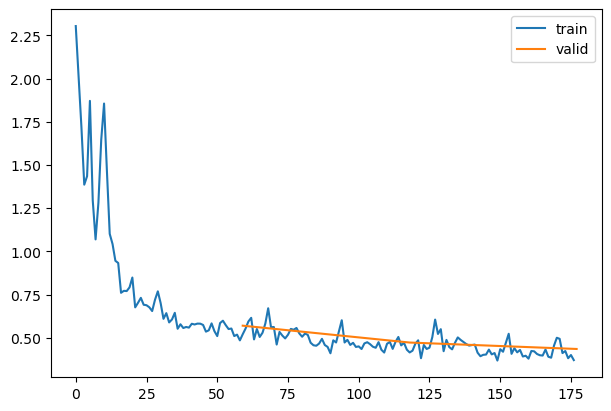

In [18]:
get_learner(SGD).fit(3, lr=0.4)

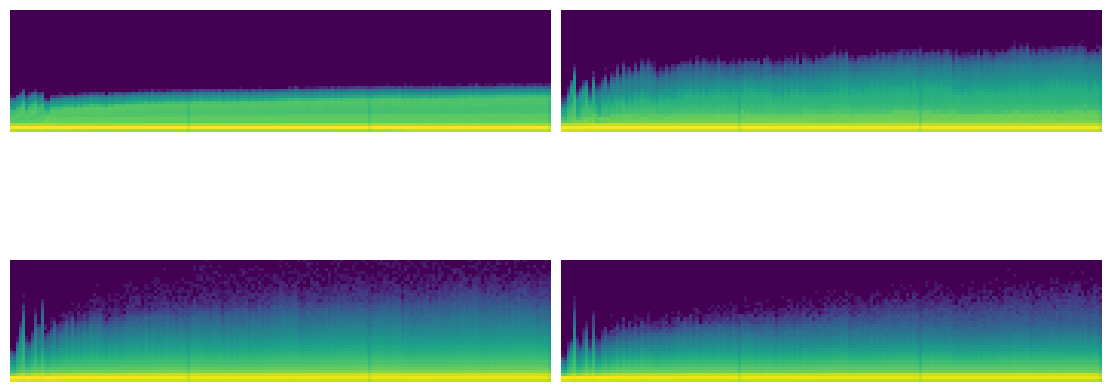

In [19]:
astats.color_dim()

epoch,train,loss,accuracy
0,train,0.7828,0.7267
0,eval,0.4748,0.8281
1,train,0.4108,0.8497
1,eval,0.4131,0.8495
2,train,0.3626,0.8680
2,eval,0.3801,0.8626


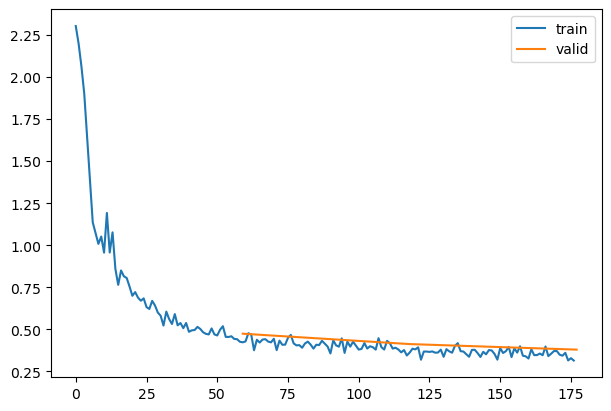

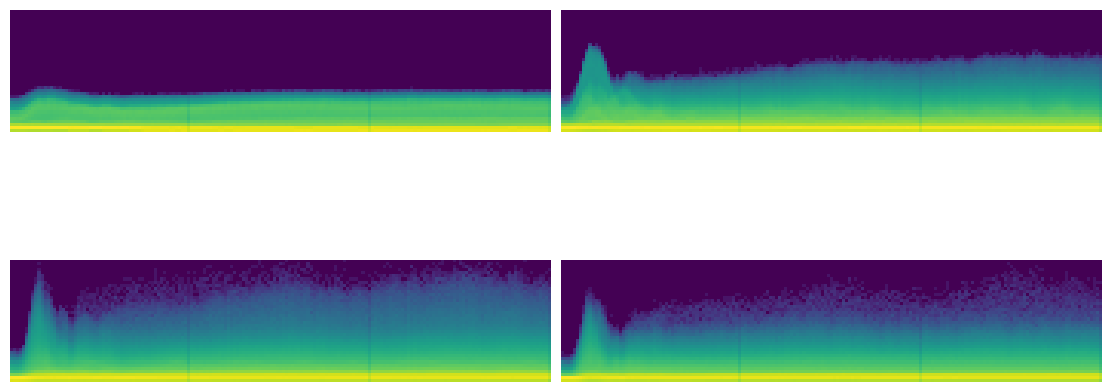

In [20]:
get_learner(Momentum).fit(3, lr=1)
astats.color_dim()